# Problem Set 4

**AS.171.402: Applied Quantum Information (Spring 2022)**

**Due Date: April 5, 2022**

In [2]:
import qiskit as qk
import numpy as np
from qiskit import Aer
from qiskit.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.circuit import Parameter
from qiskit.quantum_info.operators import Operator, Pauli

%matplotlib inline

import matplotlib.pyplot as plt

# Problem 1

In [3]:
num_qubits = 3
qr = qk.QuantumRegister(num_qubits)
cr = qk.ClassicalRegister(num_qubits)

## Part (b)

In [9]:
def state_prep():
    circ = qk.QuantumCircuit(qr, cr)
    # --- Insert state preparation circuit ---
    circ.h(qr)
    
    circ.barrier(qr)
    return circ

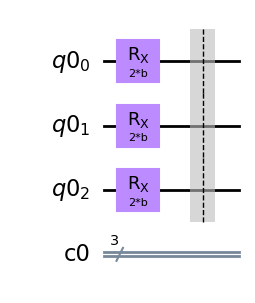

In [26]:
def mixer(beta):
    circ = qk.QuantumCircuit(qr, cr)
    # --- Insert mixer circuit ---
    circ.rx(2*beta, qr)
    
    circ.barrier(qr)
    return circ

beta = Parameter('b')
mixer(beta).draw('mpl', fold=-1)

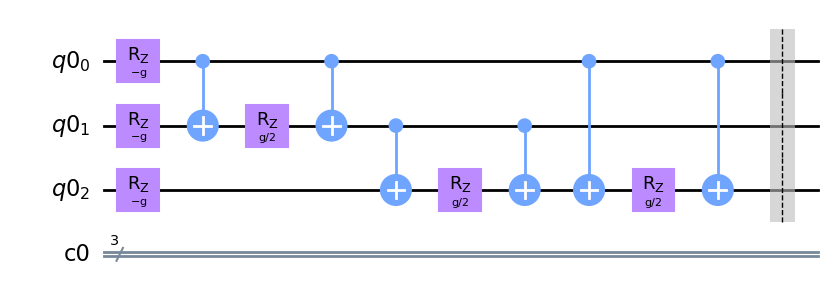

In [25]:
def cost(gamma):
    circ = qk.QuantumCircuit(qr, cr)
    # --- Insert cost circuit ---
    circ.rz(2*gamma*-1/2, qr[0]) # 1/2*sz_1
    circ.rz(2*gamma*-1/2, qr[1]) # 1/2*sz_2
    circ.rz(2*gamma*-1/2, qr[2]) # 1/2*sz_2
    # 12 ZZ Interaction
    circ.cx(qr[0], qr[1])
    circ.rz(2*gamma*1/4, qr[1])
    circ.cx(qr[0], qr[1])
    # 23 ZZ Interaction
    circ.cx(qr[1], qr[2])
    circ.rz(2*gamma*1/4, qr[2])
    circ.cx(qr[1], qr[2])
    # 13 ZZ Interaction
    circ.cx(qr[0], qr[2])
    circ.rz(2*gamma*1/4, qr[2])
    circ.cx(qr[0], qr[2])
    
    circ.barrier(qr)
    return circ

gamma = Parameter('g')
cost(gamma).draw('mpl', fold=-1)

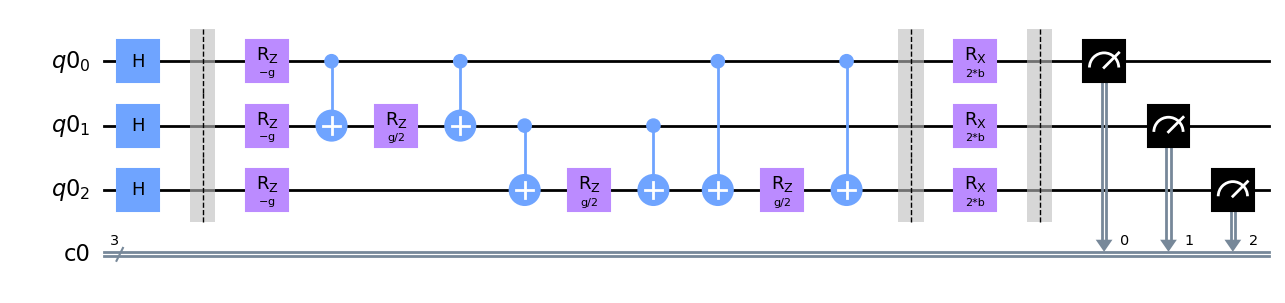

In [13]:
beta = Parameter('b')
gamma = Parameter('g')

qaoa_p1 = qk.QuantumCircuit(qr, cr)
qaoa_p1.compose(state_prep(), inplace=True)
qaoa_p1.compose(cost(gamma), inplace=True)
qaoa_p1.compose(mixer(beta), inplace=True)
# --- Insert measurement here ---

qaoa_p1.measure(qr, cr)

qaoa_p1.draw('mpl', fold=-1)

## Part (c)

Useful functions:

In [14]:
def create_state_from_outcome(outcome):
    # Turns string of 0s and 1s into quantum state
    zero = np.array([[1],[0]])
    one = np.array([[0],[1]])
    
    state = np.array([[1]])
    for elem in outcome[::-1]: # reverse bit ordering to calculate state
        if elem == '0':
            state = np.kron(state, zero)
        else:
            state = np.kron(state, one)
    return state

In [15]:
def expectation_value(counts, shots, Hc):
    # Computes expectation value with respect to Hc
    hc_matr = Hc.data # change to a numpy array
    exp_val = 0
    for outcome in counts.keys():
        state = create_state_from_outcome(outcome)
        prob = counts[outcome]/shots
        exp_val += prob*(state.conjugate().transpose() @ hc_matr @ state)
    return np.real(exp_val[0,0])

Code for varying $\beta$ and $\gamma$ and plotting $\langle H_C \rangle$ can be found in qaoa_example.ipynb.

In [18]:
# The cost Hamiltonian
ZZ12 = Operator(Pauli('ZZI'))
ZZ23 = Operator(Pauli('IZZ'))
ZZ13 = Operator(Pauli('ZIZ'))

Z1 = Operator(Pauli('ZII'))
Z2 = Operator(Pauli('IZI'))
Z3 = Operator(Pauli('IIZ'))

H_c = -1/2*Z1 - 1/2*Z2 - 1/2*Z3 + 1/4*ZZ12 + 1/4*ZZ23 + 1/4*ZZ13

In [20]:
shots = 8000
backend = Aer.get_backend('qasm_simulator')

# Set parameter ranges
beta_list = 2*np.pi*np.linspace(0,1,100)
gamma_list = np.pi*np.linspace(0,1,100)

# Vary variational parameters
all_data = []
for beta_val in beta_list:
    gamma_data = []
    for gamma_val in gamma_list:
        #print(r'b = %2.4f,  g = %2.4f' % (beta_val, gamma_val))

        # Set parameters in circuit
        qaoa_p1_set = qaoa_p1.bind_parameters({beta: beta_val, gamma: gamma_val})

        # Run simulation
        job = qk.execute(qaoa_p1_set, backend=backend, shots=shots)
        results = job.result()
        counts = results.get_counts(qaoa_p1_set)

        # Compute expectation value
        exp_val = expectation_value(counts, shots, H_c)
        
        # Append data to gamma list
        gamma_data.append(exp_val)
    
    # Append data to master list
    all_data.append(gamma_data)

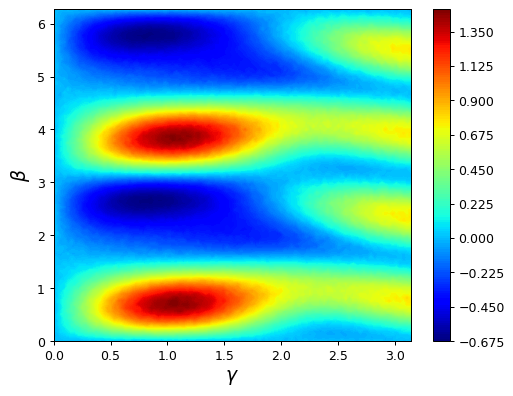

In [21]:
X, Y = np.meshgrid(gamma_list, beta_list)

fig = plt.figure(dpi=90)
ax = fig.add_subplot(111)
pl = ax.contourf(X, Y, all_data, levels=200, cmap='jet', vmin=np.min(all_data),
                vmax=np.max(all_data))

ax.set_ylabel(r'$\beta$', fontsize=15)
ax.set_xlabel(r'$\gamma$', fontsize=15)

fig.colorbar(pl)

## Part (d)

Code for finding the optimal $\beta$ and $\gamma$ can be found in qaoa_example.ipynb.

In [22]:
# Simply exhaustive search for GLOBAL maximum
opt_val = np.max(all_data)
print('Best Solution: ', opt_val)

for i in range(len(all_data)):
    for j in range(len(all_data[i])):
        if all_data[i][j] == opt_val:
            opt_i = i
            opt_j = j
            break
opt_i, opt_j

Best Solution:  1.4916250000000006


(60, 33)

In [23]:
beta_list[opt_i], gamma_list[opt_j]

(3.8079910952603555, 1.0471975511965979)

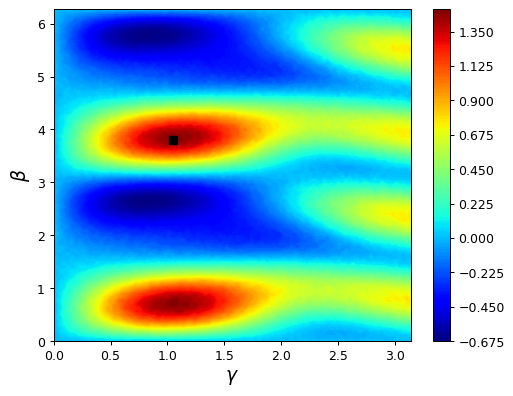

In [24]:
X, Y = np.meshgrid(gamma_list, beta_list)

fig = plt.figure(dpi=90)
ax = fig.add_subplot(111)
pl = ax.contourf(X, Y, all_data, levels=200, cmap='jet', vmin=np.min(all_data),
                vmax=np.max(all_data))

# Plot optimal value as black square
ax.plot(gamma_list[opt_j], beta_list[opt_i], 's', color='k')

ax.set_ylabel(r'$\beta$', fontsize=15)
ax.set_xlabel(r'$\gamma$', fontsize=15)\emph{See Jupyter notebook for details} 


fig.colorbar(pl)